# Dicas de avaliacao de modelos
foco em problemas de classificacao

### importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', 50)

### carregando base de dados

Kobe Bryant Shot Selection - Dados historicos sobre os arremessos de Kobe

In [41]:
df = pd.read_csv('./input/data.csv')
sample_submission = pd.read_csv('./input/sample_submission.csv')

In [42]:
df

action_type combined_shot_type  game_event_id   game_id   lat  \
0              Jump Shot          Jump Shot             10  20000012 33.97   
1              Jump Shot          Jump Shot             12  20000012 34.04   
2              Jump Shot          Jump Shot             35  20000012 33.91   
3              Jump Shot          Jump Shot             43  20000012 33.87   
4      Driving Dunk Shot               Dunk            155  20000012 34.04   
...                  ...                ...            ...       ...   ...   
30692          Jump Shot          Jump Shot            397  49900088 34.00   
30693           Tip Shot           Tip Shot            398  49900088 34.04   
30694  Running Jump Shot          Jump Shot            426  49900088 33.88   
30695          Jump Shot          Jump Shot            448  49900088 33.78   
30696          Jump Shot          Jump Shot            471  49900088 33.97   

       loc_x  loc_y     lon  minutes_remaining  period  playoffs   season  \
0        167     72 -118.10                 10       1         0  2000-01   
1       -157      0 -118.43                 10       1         0  2000-01   
2       -101    135 -118.37                  7       1         0  2000-01   
3        138    175 -118.13                  6       1         0  2000-01   
4          0      0 -118.27                  6       2         0  2000-01   
...      ...    ...     ...                ...     ...       ...      ...   
30692      1     48 -118.27                  6       4         1  1999-00   
30693      0      0 -118.27                  6       4         1  1999-00   
30694   -134    166 -118.40                  3       4         1  1999-00   
30695     31    267 -118.24                  2       4         1  1999-00   
30696      1     72 -118.27                  0       4         1  1999-00   

       seconds_remaining  shot_distance  shot_made_flag       shot_type  \
0                     27             18             nan  2PT Field Goal   
1                     22             15            0.00  2PT Field Goal   
2                     45             16            1.00  2PT Field Goal   
3                     52             22            0.00  2PT Field Goal   
4                     19              0            1.00  2PT Field Goal   
...                  ...            ...             ...             ...   
30692                  5              4            0.00  2PT Field Goal   
30693                  5              0             nan  2PT Field Goal   
30694                 28             21            1.00  2PT Field Goal   
30695                 10             26            0.00  3PT Field Goal   
30696                 39              7            0.00  2PT Field Goal   

              shot_zone_area        shot_zone_basic  shot_zone_range  \
0              Right Side(R)              Mid-Range        16-24 ft.   
1               Left Side(L)              Mid-Range         8-16 ft.   
2       Left Side Center(LC)              Mid-Range        16-24 ft.   
3      Right Side Center(RC)              Mid-Range        16-24 ft.   
4                  Center(C)        Restricted Area  Less Than 8 ft.   
...                      ...                    ...              ...   
30692              Center(C)  In The Paint (Non-RA)  Less Than 8 ft.   
30693              Center(C)        Restricted Area  Less Than 8 ft.   
30694   Left Side Center(LC)              Mid-Range        16-24 ft.   
30695              Center(C)      Above the Break 3          24+ ft.   
30696              Center(C)  In The Paint (Non-RA)  Less Than 8 ft.   

          team_id           team_name   game_date      matchup opponent  \
0      1610612747  Los Angeles Lakers  2000-10-31    LAL @ POR      POR   
1      1610612747  Los Angeles Lakers  2000-10-31    LAL @ POR      POR   
2      1610612747  Los Angeles Lakers  2000-10-31    LAL @ POR      POR   
3      1610612747  Los Angeles Lakers  2000-10-31    LAL @ POR      POR   
4      161

### analise de missings

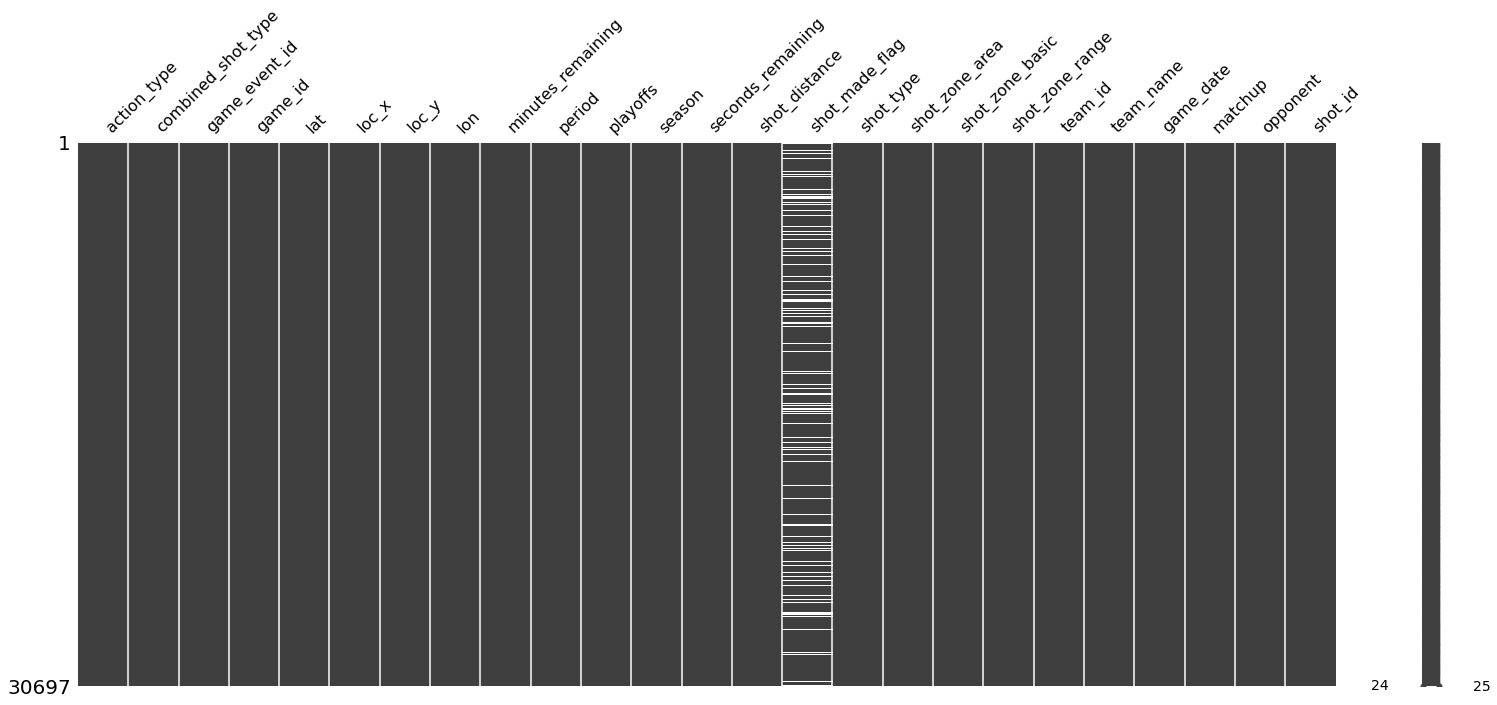

In [43]:
import missingno as msno

msno.matrix(df);

In [123]:
df_EDA= df.copy()

### ajustando e criando algumas variaveis

In [124]:
#season e game_date sao campos de datas, vamos ajustar
df_EDA.season.unique()

#o formato ta bem zuado, vou dropar essa info e trabalhar com o game_date
df_EDA.drop('season', axis=1,inplace=True)
df_EDA.game_date.unique()
df_EDA['game_date'] = pd.to_datetime(df_EDA.game_date, format='%Y-%m-%d')

#ou criar a feature year e month pra avaliar se influencia no jogo dele
df_EDA['year'] = df_EDA.game_date.apply(lambda x: x.strftime("%Y")).astype(int)
df_EDA['month'] = df_EDA.game_date.apply(lambda x: x.strftime("%m")).astype(int)

#ajustar o campo de segundos
df_EDA['seconds_remaining']=60 * df_EDA['minutes_remaining'] + df_EDA['seconds_remaining']
df_EDA['last_5_sec_in_period'] = df_EDA['seconds_remaining'] < 5

In [125]:
df_EDA['last_5_sec_in_period']  = df_EDA.last_5_sec_in_period.replace(to_replace = False,
                                value =0)

df_EDA['last_5_sec_in_period']  = df_EDA.last_5_sec_in_period.replace(to_replace = True,
                                value =1)

### descartando variaveis que nao fazem sentido

In [127]:
df_EDA.set_index('shot_id',inplace=True)

In [128]:
df_EDA=df_EDA.drop(['game_event_id','game_id','team_id','game_date','team_name','matchup'],axis=1)

### separando tipos de variaveis

In [129]:
target = df_EDA[["shot_made_flag"]]

importante para analisarmos de forma diferente

In [130]:
dfn = df_EDA.select_dtypes(exclude=['object','bool'])
dfn=dfn.drop("shot_made_flag",axis=1)
dfn.columns

Index(['lat', 'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period',
       'playoffs', 'seconds_remaining', 'shot_distance', 'year', 'month',
       'last_5_sec_in_period'],
      dtype='object')

In [131]:
dfs = df_EDA.select_dtypes(include=['object','bool'])
dfs.columns

Index(['action_type', 'combined_shot_type', 'shot_type', 'shot_zone_area',
       'shot_zone_basic', 'shot_zone_range', 'opponent'],
      dtype='object')

## numericas

### analisando correlacao
Precisamos retirar correlacao para nao atrapalhar o entendimento do modelo

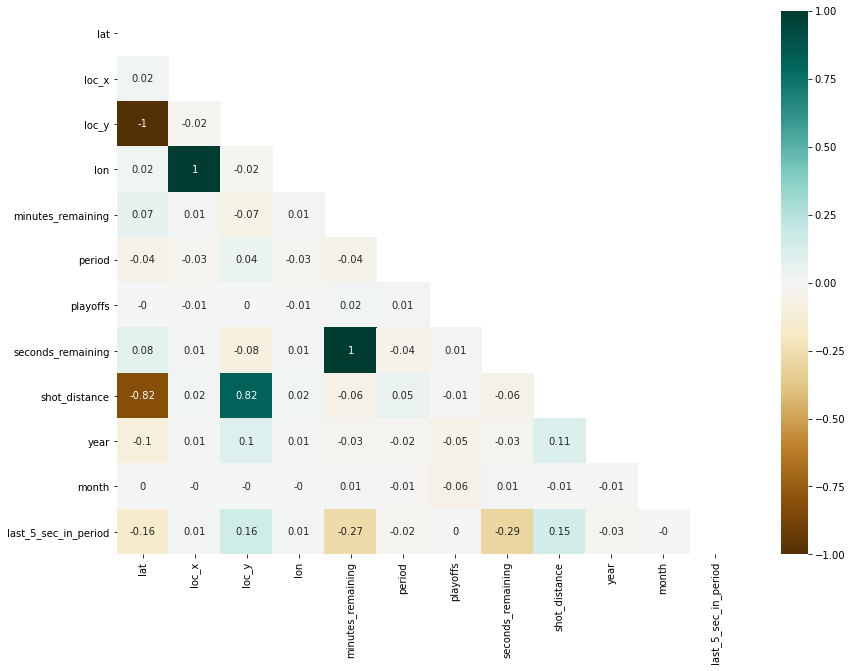

In [132]:
matrix = np.triu(dfn.corr())

fig, axs = plt.subplots(figsize=(14,10))

sns.heatmap(np.round(dfn.corr(),2), cmap ='BrBG' ,annot=True, mask=matrix);

#### selecionando apenas as variaveis com baixa correlacao

In [133]:
corr = dfn.corr()

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = dfn.columns[columns]

dfn.shape

dfn_corr = dfn[selected_columns]
dfn_corr.shape

(30697, 10)

### analisando outliers

necessario decidir se drop ou nao os outliers

In [134]:
dfn.describe()

lat     loc_x     loc_y       lon  minutes_remaining    period  \
count 30,697.00 30,697.00 30,697.00 30,697.00          30,697.00 30,697.00   
mean      33.95      7.11     91.11   -118.26               4.89      2.52   
std        0.09    110.12     87.79      0.11               3.45      1.15   
min       33.25   -250.00    -44.00   -118.52               0.00      1.00   
25%       33.88    -68.00      4.00   -118.34               2.00      1.00   
50%       33.97      0.00     74.00   -118.27               5.00      3.00   
75%       34.04     95.00    160.00   -118.17               8.00      3.00   
max       34.09    248.00    791.00   -118.02              11.00      7.00   

       playoffs  seconds_remaining  shot_distance      year     month  \
count 30,697.00          30,697.00      30,697.00 30,697.00 30,697.00   
mean       0.15             321.50          13.44  2,006.10      5.58   
std        0.35             208.18           9.37      4.84      4.16   
min        0.00               0.00           0.00  1,996.00      1.00   
25%        0.00             142.00           5.00  2,002.00      2.00   
50%        0.00             304.00          15.00  2,006.00      4.00   
75%        0.00             498.00          21.00  2,010.00     11.00   
max        1.00             714.00          79.00  2,016.00     12.00   

       last_5_sec_in_period  
count             30,697.00  
mean                   0.03  
std                    0.18  
min                    0.00  
25%                    0.00  
50%                    0.00  
75%                    0.00  
max                    1.00

In [135]:
def detect_outliers(series, whis=1.5):
    q75, q25 = np.percentile(series, [75 ,25])
    iqr = q75 - q25
    return ~((series - series.median()).abs() <= (whis * iqr))

A=[]
for varx in dfn.columns:
    A.append(pd.DataFrame(detect_outliers(dfn[varx]).value_counts(normalize=True)))
a = pd.concat(A,axis=1).fillna(0)
a

lat  loc_x  loc_y  lon  minutes_remaining  period  playoffs  \
False 0.99   1.00   0.99 1.00               1.00    1.00      0.85   
True  0.01   0.00   0.01 0.00               0.00    0.00      0.15   

       seconds_remaining  shot_distance  year  month  last_5_sec_in_period  
False               1.00           1.00  1.00   1.00                  0.97  
True                0.00           0.00  0.00   0.00                  0.03

#### muito cuidado, se vc dropar as linhas, vai acabar desalinhando o frame, assim nao vai conseguir concatenar com a dfs. Lembrar de usar um merge com o indice, e nao dar reset_index()

aparentemente nenhuma variavel apresenta mtos outliers
(boxplots tb sao legais aqui)

## categoricas

### analisando correlacao

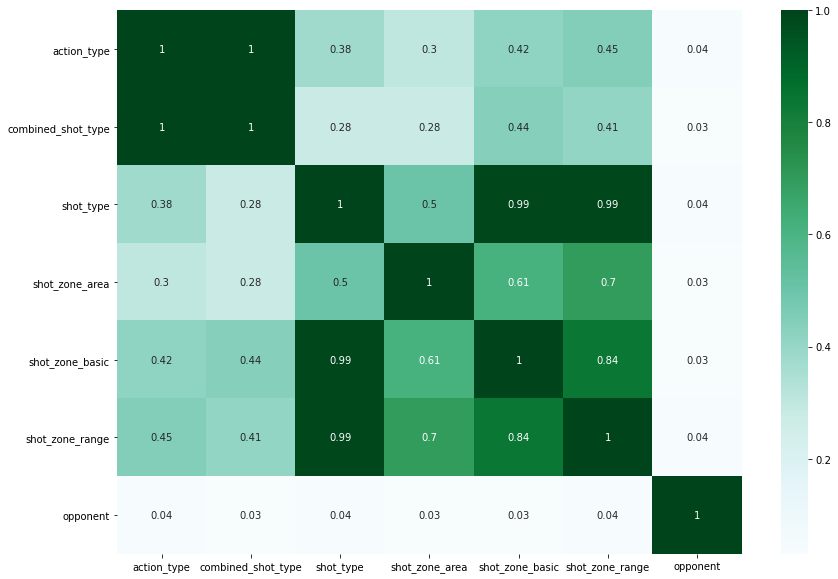

In [136]:
from dython.nominal import compute_associations

mtz_v=compute_associations(dfs, theil_u=False)

fig, axs = plt.subplots(figsize=(14,10))
sns.heatmap(np.round(mtz_v,2), cmap ='BuGn' ,annot=True);

#### selecionando apenas as variaveis com baixa correlacao

In [137]:
corr = np.round(mtz_v,2)

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = dfs.columns[columns]

In [138]:
dfs.shape

(30697, 7)

In [139]:
dfs = dfs[selected_columns]
dfs.shape

(30697, 4)

### feature transformation

### numerical

#### original

In [140]:
dfn_corr

lat  loc_x  loc_y  minutes_remaining  period  playoffs  \
shot_id                                                            
1       33.97    167     72                 10       1         0   
2       34.04   -157      0                 10       1         0   
3       33.91   -101    135                  7       1         0   
4       33.87    138    175                  6       1         0   
5       34.04      0      0                  6       2         0   
...       ...    ...    ...                ...     ...       ...   
30693   34.00      1     48                  6       4         1   
30694   34.04      0      0                  6       4         1   
30695   33.88   -134    166                  3       4         1   
30696   33.78     31    267                  2       4         1   
30697   33.97      1     72                  0       4         1   

         shot_distance  year  month  last_5_sec_in_period  
shot_id                                                    
1                   18  2000     10                  0.00  
2                   15  2000     10                  0.00  
3                   16  2000     10                  0.00  
4                   22  2000     10                  0.00  
5                    0  2000     10                  0.00  
...                ...   ...    ...                   ...  
30693                4  2000      6                  0.00  
30694                0  2000      6                  0.00  
30695               21  2000      6                  0.00  
30696               26  2000      6                  0.00  
30697                7  2000      6                  0.00  

[30697 rows x 10 columns]

#### bins

In [141]:
dfn_bins = dfn_corr.copy()

for i in dfn_corr.columns:
    
    dfn_bins[i]=pd.cut(dfn_bins[i],20,labels=range(20))

In [260]:
dfn_bins = dfn_bins.astype(int)
dfn_bins.head()

lat  loc_x  loc_y  minutes_remaining  period  playoffs  \
shot_id                                                           
1         17     16      2                 18       0         0   
2         18      3      1                 18       0         0   
3         15      5      4                 12       0         0   
4         14     15      5                 10       0         0   
5         18     10      1                 10       3         0   

         shot_distance  year  month  last_5_sec_in_period  
shot_id                                                    
1                    4     3     16                     0  
2                    3     3     16                     0  
3                    4     3     16                     0  
4                    5     3     16                     0  
5                    0     3     16                     0

In [143]:
dfn_bins.describe()

lat     loc_x     loc_y  minutes_remaining    period  playoffs  \
count 30,697.00 30,697.00 30,697.00          30,697.00 30,697.00 30,697.00   
mean      16.18      9.91      2.82               8.42      4.57      2.78   
std        2.03      4.43      2.03               6.19      3.49      6.72   
min        0.00      0.00      0.00               0.00      0.00      0.00   
25%       15.00      7.00      1.00               3.00      0.00      0.00   
50%       17.00     10.00      2.00               9.00      6.00      0.00   
75%       18.00     13.00      4.00              14.00      6.00      0.00   
max       19.00     19.00     19.00              19.00     19.00     19.00   

       shot_distance      year     month  last_5_sec_in_period  
count      30,697.00 30,697.00 30,697.00             30,697.00  
mean            3.06      9.10      7.84                  0.65  
std             2.28      4.83      7.46                  3.45  
min             0.00      0.00      0.00                  0.00  
25%             1.00      5.00      1.00                  0.00  
50%             3.00      9.00      5.00                  0.00  
75%             5.00     13.00     18.00                  0.00  
max            19.00     19.00     19.00                 19.00

#### normalization

In [208]:
from sklearn.preprocessing import StandardScaler

In [262]:
dfn_scl = dfn.copy()
dfn_scl.head()

lat  loc_x  loc_y     lon  minutes_remaining  period  playoffs  \
shot_id                                                                    
1       33.97    167     72 -118.10                 10       1         0   
2       34.04   -157      0 -118.43                 10       1         0   
3       33.91   -101    135 -118.37                  7       1         0   
4       33.87    138    175 -118.13                  6       1         0   
5       34.04      0      0 -118.27                  6       2         0   

         seconds_remaining  shot_distance  year  month  last_5_sec_in_period  
shot_id                                                                       
1                      627             18  2000     10                  0.00  
2                      622             15  2000     10                  0.00  
3                      465             16  2000     10                  0.00  
4                      412             22  2000     10                  0.00  
5                      379              0  2000     10                  0.00

In [263]:
scaler = StandardScaler()
dfn_scl = pd.DataFrame(scaler.fit_transform(dfn_scl),
                     columns = dfn_scl.columns,
                      index = dfn_scl.index)
dfn_scl.head()

lat  loc_x  loc_y   lon  minutes_remaining  period  playoffs  \
shot_id                                                                  
1        0.22   1.45  -0.22  1.45               1.48   -1.32     -0.41   
2        1.04  -1.49  -1.04 -1.49               1.48   -1.32     -0.41   
3       -0.50  -0.98   0.50 -0.98               0.61   -1.32     -0.41   
4       -0.96   1.19   0.96  1.19               0.32   -1.32     -0.41   
5        1.04  -0.06  -1.04 -0.06               0.32   -0.45     -0.41   

         seconds_remaining  shot_distance  year  month  last_5_sec_in_period  
shot_id                                                                       
1                     1.47           0.49 -1.26   1.06                 -0.19  
2                     1.44           0.17 -1.26   1.06                 -0.19  
3                     0.69           0.27 -1.26   1.06                 -0.19  
4                     0.43           0.91 -1.26   1.06                 -0.19  
5                     0.28          -1.43 -1.26   1.06                 -0.19

### categorical

#### label encoder

In [264]:
from sklearn.preprocessing import LabelEncoder

In [265]:
dfs_label_enc = dfs.copy()
dfs_label_enc.head()

action_type       shot_type         shot_zone_area opponent
shot_id                                                                   
1                Jump Shot  2PT Field Goal          Right Side(R)      POR
2                Jump Shot  2PT Field Goal           Left Side(L)      POR
3                Jump Shot  2PT Field Goal   Left Side Center(LC)      POR
4                Jump Shot  2PT Field Goal  Right Side Center(RC)      POR
5        Driving Dunk Shot  2PT Field Goal              Center(C)      POR

In [266]:
labelencoder = LabelEncoder()

for i in dfs_label_enc.columns:
    dfs_label_enc[i] = labelencoder.fit_transform(dfs_label_enc[i]).astype(int)


In [267]:
dfs_label_enc.head()

action_type  shot_type  shot_zone_area  opponent
shot_id                                                  
1                 26          0               5        25
2                 26          0               3        25
3                 26          0               2        25
4                 26          0               4        25
5                  5          0               1        25

#### One hot encoding

In [268]:
from sklearn.preprocessing import OneHotEncoder

In [269]:
dfs_label_ohe = dfs.copy()
dfs_label_ohe.head()

action_type       shot_type         shot_zone_area opponent
shot_id                                                                   
1                Jump Shot  2PT Field Goal          Right Side(R)      POR
2                Jump Shot  2PT Field Goal           Left Side(L)      POR
3                Jump Shot  2PT Field Goal   Left Side Center(LC)      POR
4                Jump Shot  2PT Field Goal  Right Side Center(RC)      POR
5        Driving Dunk Shot  2PT Field Goal              Center(C)      POR

In [271]:
ohe = OneHotEncoder(handle_unknown='ignore')

dfs_label_ohe = pd.DataFrame(ohe.fit_transform(dfs_label_ohe).toarray(),
                     columns = ohe.get_feature_names(),
                     index= dfs_label_ohe.index)
# merge with main df bridge_df on key values
dfs_label_ohe.head()

x0_Alley Oop Dunk Shot  x0_Alley Oop Layup shot  \
shot_id                                                    
1                          0.00                     0.00   
2                          0.00                     0.00   
3                          0.00                     0.00   
4                          0.00                     0.00   
5                          0.00                     0.00   

         x0_Cutting Finger Roll Layup Shot  x0_Cutting Layup Shot  \
shot_id                                                             
1                                     0.00                   0.00   
2                                     0.00                   0.00   
3                                     0.00                   0.00   
4                                     0.00                   0.00   
5                                     0.00                   0.00   

         x0_Driving Bank shot  x0_Driving Dunk Shot  \
shot_id                                               
1                        0.00                  0.00   
2                        0.00                  0.00   
3                        0.00                  0.00   
4                        0.00                  0.00   
5                        0.00                  1.00   

         x0_Driving Finger Roll Layup Shot  x0_Driving Finger Roll Shot  \
shot_id                                                                   
1                                     0.00                         0.00   
2                                     0.00                         0.00   
3                                     0.00                         0.00   
4                                     0.00                         0.00   
5                                     0.00                         0.00   

         x0_Driving Floating Bank Jump Shot  x0_Driving Floating Jump Shot  \
shot_id                                                                      
1                                      0.00                           0.00   
2                                      0.00                           0.00   
3                                      0.00                           0.00   
4                                      0.00                           0.00   
5                                      0.00                           0.00   

         x0_Driving Hook Shot  x0_Driving Jump shot  x0_Driving Layup Shot  \
shot_id                                                                      
1                        0.00                  0.00                   0.00   
2                        0.00                  0.00                   0.00   
3                        0.00                  0.00                   0.00   
4                        0.00                  0.00                   0.00   
5                        0.00                  0.00                   0.00   

         x0_Driving Reverse Layup Shot  x0_Driving Slam Dunk Shot  \
shot_id                                                             
1                                 0.00                       0.00   
2                                 0.00                       0.00   
3                                 0.00                       0.00   
4                                 0.00                       0.00   
5                                 0.00                       0.00   

         x0_Dunk Shot  x0_Fadeaway Bank shot  x0_Fadeaway Jump Shot  \
shot_id                                                               
1                0.00                   0.00                   0.00   
2                0.00                   0.00                   0.00   
3                0.00                   0.00                   0.00   
4                0.00                   0.00                   0.00   
5                0.00                   0.00                   0.00   

         x0_Finger Roll Layup Shot  x0_Finger Roll Shot  \
shot_id                                                  

#### teremos 6 possiveis bds, 3 variacoes de num + 2 variacoes de cat

In [272]:
# numericas
bd_num = [dfn_corr,dfn_scl,dfn_bins]

# categoricas
bd_cat = [dfs_label_enc,dfs_label_ohe]


### combinando tudo

In [536]:
unknown_mask = sample_submission.set_index('shot_id').index
unknown_mask

Int64Index([    1,     8,    17,    20,    33,    34,    35,    36,    37,
               38,
            ...
            30647, 30649, 30656, 30660, 30665, 30669, 30681, 30683, 30687,
            30694],
           dtype='int64', name='shot_id', length=5000)

In [537]:
BD_train=[]
BD_test=[]

for i in bd_num:
    for j in bd_cat:
        bd = pd.concat([i,j,target],axis=1)
        
        
        bd_train = bd.loc[~bd.index.isin(unknown_mask)]
        bd_test = bd.loc[bd.index.isin(unknown_mask)]

        BD_train.append(bd_train)
        BD_test.append(bd_test)

### feature selection

#### variance thereshold

In [538]:
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2

In [539]:
threshold = 0.90
feats_01 =[]

for bd in BD_train:
    
    X = bd.drop("shot_made_flag", axis=1)
    y = bd.shot_made_flag
    
    vt = VarianceThreshold().fit(X)

    # Find feature names
    feat_var_threshold = X.columns[vt.variances_ > threshold * (1-threshold)]
    
    feats_01.append(list(feat_var_threshold))

feats_01

[['loc_x',
  'loc_y',
  'minutes_remaining',
  'period',
  'playoffs',
  'shot_distance',
  'year',
  'month',
  'action_type',
  'shot_type',
  'shot_zone_area',
  'opponent'],
 ['loc_x',
  'loc_y',
  'minutes_remaining',
  'period',
  'playoffs',
  'shot_distance',
  'year',
  'month',
  'x0_Jump Shot',
  'x1_2PT Field Goal',
  'x1_3PT Field Goal',
  'x2_Center(C)',
  'x2_Left Side Center(LC)',
  'x2_Left Side(L)',
  'x2_Right Side Center(RC)',
  'x2_Right Side(R)'],
 ['lat',
  'loc_x',
  'loc_y',
  'lon',
  'minutes_remaining',
  'period',
  'playoffs',
  'seconds_remaining',
  'shot_distance',
  'year',
  'month',
  'last_5_sec_in_period',
  'action_type',
  'shot_type',
  'shot_zone_area',
  'opponent'],
 ['lat',
  'loc_x',
  'loc_y',
  'lon',
  'minutes_remaining',
  'period',
  'playoffs',
  'seconds_remaining',
  'shot_distance',
  'year',
  'month',
  'last_5_sec_in_period',
  'x0_Jump Shot',
  'x1_2PT Field Goal',
  'x1_3PT Field Goal',
  'x2_Center(C)',
  'x2_Left Side Cente

#### Top 20 most important features

In [540]:
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier

In [541]:
feats_02 =[]
for bd in BD_train:
    
    X = bd.drop("shot_made_flag", axis=1)
    y = bd.shot_made_flag

    model = RandomForestClassifier()
    model.fit(X, y)

    feature_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=["importance"])
    feat_imp_20 = feature_imp.sort_values("importance", ascending=False).head(20).index
    
    feats_02.append(list(feat_imp_20))

In [542]:
feats_02

[['opponent',
  'action_type',
  'loc_x',
  'year',
  'lat',
  'loc_y',
  'minutes_remaining',
  'shot_distance',
  'month',
  'period',
  'shot_zone_area',
  'playoffs',
  'shot_type',
  'last_5_sec_in_period'],
 ['loc_x',
  'year',
  'minutes_remaining',
  'loc_y',
  'lat',
  'shot_distance',
  'month',
  'period',
  'x0_Jump Shot',
  'x0_Layup Shot',
  'playoffs',
  'x3_HOU',
  'x3_DEN',
  'x3_PHX',
  'x3_SAS',
  'x3_SAC',
  'x2_Center(C)',
  'x3_POR',
  'x3_MIN',
  'x0_Driving Layup Shot'],
 ['seconds_remaining',
  'action_type',
  'opponent',
  'year',
  'lat',
  'loc_x',
  'lon',
  'loc_y',
  'month',
  'shot_distance',
  'minutes_remaining',
  'period',
  'shot_zone_area',
  'playoffs',
  'shot_type',
  'last_5_sec_in_period'],
 ['seconds_remaining',
  'year',
  'lat',
  'lon',
  'loc_x',
  'loc_y',
  'minutes_remaining',
  'shot_distance',
  'month',
  'x0_Jump Shot',
  'period',
  'x0_Layup Shot',
  'playoffs',
  'x0_Driving Layup Shot',
  'x3_HOU',
  'x3_DEN',
  'x3_SAS',
  '

#### Univariate feature selection
Select top 20 features using  chi2  test. Features must be positive before applying test.

In [543]:
from sklearn.preprocessing import MinMaxScaler

In [544]:
feats_03 =[]
for bd in BD_train:
    
    X = bd.drop("shot_made_flag", axis=1)
    y = bd.shot_made_flag

    X_minmax = MinMaxScaler(feature_range=(0,1)).fit_transform(X)
    X_scored = SelectKBest(score_func=chi2, k='all').fit(X_minmax, y)
    feature_scoring = pd.DataFrame({
            'feature': X.columns,
            'score': X_scored.scores_
        })

    feat_scored_20 = feature_scoring.sort_values('score', ascending=False).head(20)['feature'].values
    feats_03.append(list(feat_scored_20))
    
feats_03

[['shot_type',
  'last_5_sec_in_period',
  'shot_distance',
  'shot_zone_area',
  'loc_y',
  'lat',
  'minutes_remaining',
  'period',
  'year',
  'opponent',
  'month',
  'playoffs',
  'action_type',
  'loc_x'],
 ['x0_Jump Shot',
  'x0_Driving Layup Shot',
  'x0_Slam Dunk Shot',
  'x1_3PT Field Goal',
  'x0_Driving Dunk Shot',
  'x2_Center(C)',
  'x0_Running Jump Shot',
  'last_5_sec_in_period',
  'x0_Jump Bank Shot',
  'x0_Pullup Jump shot',
  'x2_Left Side Center(LC)',
  'x0_Dunk Shot',
  'x0_Alley Oop Dunk Shot',
  'shot_distance',
  'x0_Turnaround Jump Shot',
  'x1_2PT Field Goal',
  'x2_Right Side Center(RC)',
  'x0_Fadeaway Jump Shot',
  'x0_Reverse Dunk Shot',
  'x2_Back Court(BC)'],
 ['shot_type',
  'last_5_sec_in_period',
  'shot_distance',
  'shot_zone_area',
  'loc_y',
  'lat',
  'seconds_remaining',
  'minutes_remaining',
  'period',
  'year',
  'opponent',
  'month',
  'playoffs',
  'action_type',
  'lon',
  'loc_x'],
 ['x0_Jump Shot',
  'x0_Driving Layup Shot',
  'x0_Sla

#### Recursive Feature Elimination
Select 20 features from using recursive feature elimination (RFE) with logistic regression model.

In [545]:
from sklearn.linear_model import LogisticRegression

In [546]:
feats_04 =[]

for bd in BD_train:
    
    X = bd.drop("shot_made_flag", axis=1)
    y = bd.shot_made_flag

    rfe = RFE(LogisticRegression(), 20)
    rfe.fit(X, y)

    feature_rfe_scoring = pd.DataFrame({
            'feature': X.columns,
            'score': rfe.ranking_
        })

    feat_rfe_20 = feature_rfe_scoring[feature_rfe_scoring['score'] == 1]['feature'].values
    feats_04.append(list(feat_rfe_20))

In [547]:
feats_04

[['lat',
  'loc_x',
  'loc_y',
  'minutes_remaining',
  'period',
  'playoffs',
  'shot_distance',
  'year',
  'month',
  'last_5_sec_in_period',
  'action_type',
  'shot_type',
  'shot_zone_area',
  'opponent'],
 ['x0_Alley Oop Dunk Shot',
  'x0_Driving Dunk Shot',
  'x0_Driving Finger Roll Layup Shot',
  'x0_Driving Finger Roll Shot',
  'x0_Driving Jump shot',
  'x0_Driving Slam Dunk Shot',
  'x0_Fadeaway Bank shot',
  'x0_Finger Roll Shot',
  'x0_Hook Bank Shot',
  'x0_Hook Shot',
  'x0_Jump Shot',
  'x0_Layup Shot',
  'x0_Reverse Dunk Shot',
  'x0_Reverse Slam Dunk Shot',
  'x0_Running Dunk Shot',
  'x0_Running Finger Roll Shot',
  'x0_Running Hook Shot',
  'x0_Slam Dunk Shot',
  'x0_Tip Shot',
  'x2_Back Court(BC)'],
 ['lat',
  'loc_x',
  'loc_y',
  'lon',
  'minutes_remaining',
  'period',
  'playoffs',
  'seconds_remaining',
  'shot_distance',
  'year',
  'month',
  'last_5_sec_in_period',
  'action_type',
  'shot_type',
  'shot_zone_area',
  'opponent'],
 ['x0_Alley Oop Dunk Sh

### escolha das features

In [608]:
ind=2
features = np.hstack([
    feats_01[ind],
    feats_02[ind],
    feats_03[ind],
    feats_04[ind]
    ])

features = np.unique(features)
print('Final features set:\n')
for f in features:
    print("\t-{}".format(f))
    
print("antes tinhamos ", BD[ind].shape[1])
print("agora temos ",len(features))

bd = BD_train[ind]
X = bd[features]
y = bd.shot_made_flag

X.shape

Final features set:

	-action_type
	-last_5_sec_in_period
	-lat
	-loc_x
	-loc_y
	-lon
	-minutes_remaining
	-month
	-opponent
	-period
	-playoffs
	-seconds_remaining
	-shot_distance
	-shot_type
	-shot_zone_area
	-year
antes tinhamos  17
agora temos  16


(25697, 16)

### Modeling

In [609]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [610]:
X_train.shape, X_test.shape

((20557, 16), (5140, 16))

In [611]:
from skopt import dummy_minimize
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

#### criando uma referencia

In [612]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [613]:
clf = [(GaussianNB(), "NB"),
       (KNeighborsClassifier(),"knn"),
       (LogisticRegression(),"lr"),
       (DecisionTreeClassifier(),'dt'),
       (LGBMClassifier(),'lgb')]

In [614]:
for i in clf:
    
    model = i[0]
    lbl = i[1]
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:,1]
    print("model",lbl, " - auc: ", -roc_auc_score(y_test, pred),  " - logloss: ", -log_loss(y_test, pred_proba))
    

model NB  - auc:  -0.5845984308801029  - logloss:  -1.0827625633817577
model knn  - auc:  -0.6070869398970491  - logloss:  -2.0344206280295127
model lr  - auc:  -0.5722908499921131  - logloss:  -0.6700760648493319
model dt  - auc:  -0.5749201661305539  - logloss:  -14.501079654128661
model lgb  - auc:  -0.6508580875100731  - logloss:  -0.6109648558029604


### Random Search

In [615]:
def treinar_model(params):
    
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print(params)
    print("")
    
    mdl = LGBMClassifier(learning_rate = learning_rate,
                         num_leaves = num_leaves,
                         min_child_samples = min_child_samples,
                         subsample = subsample,
                         colsample_bytree = colsample_bytree,
                         random_state = 0,
                         subsample_freq=1,
                         n_estimators =100)
    
    mdl.fit(X_train, y_train)
    pred = mdl.predict_proba(X_test)[:,1]
    
    return -log_loss(y_test, pred)

space = [(1e-3, 1e-1, 'log-uniform'),
        (2,128),
        (1,100),
        (0.05,1.0),
        (0.1,1.0)]

In [616]:
resultado = dummy_minimize(treinar_model,
                           space,
                           random_state = 1, 
                           verbose=1,
                           n_calls=30)

Iteration No: 1 started. Evaluating function at random point.
[0.09871192514273254, 74, 10, 0.3372159440002478, 0.23208030173540176]

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.3354
Function value obtained: -0.6270
Current minimum: -0.6270
Iteration No: 2 started. Evaluating function at random point.
[0.001529949829431263, 78, 72, 0.3782826906908954, 0.457090726807603]

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3615
Function value obtained: -0.6745
Current minimum: -0.6745
Iteration No: 3 started. Evaluating function at random point.
[0.01195730942971637, 128, 19, 0.5483207515942279, 0.49910760440160107]

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.5256
Function value obtained: -0.6309
Current minimum: -0.6745
Iteration No: 4 started. Evaluating function at random point.
[0.0028784217488024557, 16, 51, 0.9182639233502714, 0.5114843271882895]

Iteration No: 4 ended. Evaluation done at random point.
Time tak

In [617]:
resultado.x, resultado.fun

([0.0010878688833867167, 43, 83, 0.98941803446117, 0.7733490889418555],
 -0.6748839531606671)

### Bayesian Optimization

In [598]:
from skopt import gp_minimize

In [599]:
bo = gp_minimize(treinar_model,
           space,
           random_state=1,
           verbose=1,
           n_calls=30,
           n_random_starts=5)

Iteration No: 1 started. Evaluating function at random point.
[0.09871192514273254, 120, 14, 0.9990884895579377, 0.3124800792567785]

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.4688
Function value obtained: -0.6203
Current minimum: -0.6203
Iteration No: 2 started. Evaluating function at random point.
[0.006210998932353835, 51, 67, 0.9387621172657304, 0.8616798250174156]

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.4177
Function value obtained: -0.6354
Current minimum: -0.6354
Iteration No: 3 started. Evaluating function at random point.
[0.004232013397179603, 68, 45, 0.2680983530433343, 0.5809725180523154]

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.4233
Function value obtained: -0.6523
Current minimum: -0.6523
Iteration No: 4 started. Evaluating function at random point.
[0.0672858974212934, 60, 44, 0.9421713999524447, 0.8005503127028804]

Iteration No: 4 ended. Evaluation done at random point.
Time taken:

In [600]:
bo.x, bo.fun

([0.001, 2, 1, 0.05, 0.1], -0.6843737636918477)

In [601]:
from skopt.plots import plot_convergence

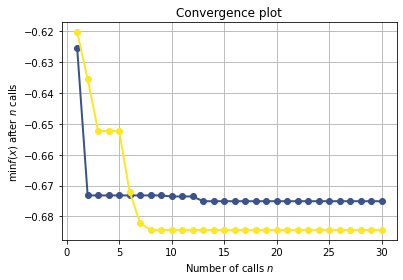

In [602]:
plot_convergence(resultado, bo)

### modelo final

In [603]:
resultado.x, resultado.fun

([0.0014697585967435188, 40, 9, 0.9149259627034465, 0.36903710098874454],
 -0.6750642952732321)

In [627]:
learning_rate = resultado.x[0]
num_leaves = resultado.x[1]
min_child_samples = resultado.x[2]
subsample = resultado.x[3]
colsample_bytree = resultado.x[4]

mdl = LGBMClassifier(learning_rate = learning_rate,
                     num_leaves = num_leaves,
                     min_child_samples = min_child_samples,
                     subsample = subsample,
                     colsample_bytree = colsample_bytree,
                     random_state = 0,
                     subsample_freq=1,
                     n_estimators =100)

mdl.fit(X_train, y_train)
pred = mdl.predict_proba(X_test)[:,1]

-log_loss(y_test, pred)


-0.6752208447016329

### Function que testa um bd de cada vez

In [619]:
len(BD_train)

6

In [635]:
RES=[]

for ind in range(6):
    
    features = np.hstack([
        feats_01[ind],
        feats_02[ind],
        feats_03[ind],
        feats_04[ind]
        ])

    features = np.unique(features)

    print("antes tinhamos ", BD[ind].shape[1])
    print("agora temos ",len(features))

    bd = BD_train[ind]
    X = bd[features]
    y = bd.shot_made_flag

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

    resultado = dummy_minimize(treinar_model,
                               space,
                               random_state = 1, 
                               verbose=1,
                               n_calls=30)

    res = (ind,resultado.x, resultado.fun)
    
    RES.append(res)


antes tinhamos  15
agora temos  14
Iteration No: 1 started. Evaluating function at random point.
[0.09871192514273254, 74, 10, 0.3372159440002478, 0.23208030173540176]

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.3141
Function value obtained: -0.6233
Current minimum: -0.6233
Iteration No: 2 started. Evaluating function at random point.
[0.001529949829431263, 78, 72, 0.3782826906908954, 0.457090726807603]

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3441
Function value obtained: -0.6768
Current minimum: -0.6768
Iteration No: 3 started. Evaluating function at random point.
[0.01195730942971637, 128, 19, 0.5483207515942279, 0.49910760440160107]

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.5259
Function value obtained: -0.6291
Current minimum: -0.6768
Iteration No: 4 started. Evaluating function at random point.
[0.0028784217488024557, 16, 51, 0.9182639233502714, 0.5114843271882895]

Iteration No: 4 ended. Evalua

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.4279
Function value obtained: -0.6226
Current minimum: -0.6226
Iteration No: 2 started. Evaluating function at random point.
[0.001529949829431263, 78, 72, 0.3782826906908954, 0.457090726807603]

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.4558
Function value obtained: -0.6754
Current minimum: -0.6754
Iteration No: 3 started. Evaluating function at random point.
[0.01195730942971637, 128, 19, 0.5483207515942279, 0.49910760440160107]

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.5919
Function value obtained: -0.6286
Current minimum: -0.6754
Iteration No: 4 started. Evaluating function at random point.
[0.0028784217488024557, 16, 51, 0.9182639233502714, 0.5114843271882895]

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.2179
Function value obtained: -0.6648
Current minimum: -0.6754
Iteration No: 5 started. Evaluating function at random point.
[0.

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3860
Function value obtained: -0.6767
Current minimum: -0.6767
Iteration No: 3 started. Evaluating function at random point.
[0.01195730942971637, 128, 19, 0.5483207515942279, 0.49910760440160107]

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.5421
Function value obtained: -0.6323
Current minimum: -0.6767
Iteration No: 4 started. Evaluating function at random point.
[0.0028784217488024557, 16, 51, 0.9182639233502714, 0.5114843271882895]

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1800
Function value obtained: -0.6671
Current minimum: -0.6767
Iteration No: 5 started. Evaluating function at random point.
[0.007267702383040958, 96, 97, 0.7894697745197069, 0.7443734643715278]

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.5396
Function value obtained: -0.6374
Current minimum: -0.6767
Iteration No: 6 started. Evaluating function at random point.
[0

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.6404
Function value obtained: -0.6292
Current minimum: -0.6753
Iteration No: 4 started. Evaluating function at random point.
[0.0028784217488024557, 16, 51, 0.9182639233502714, 0.5114843271882895]

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.2359
Function value obtained: -0.6639
Current minimum: -0.6753
Iteration No: 5 started. Evaluating function at random point.
[0.007267702383040958, 96, 97, 0.7894697745197069, 0.7443734643715278]

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.5834
Function value obtained: -0.6350
Current minimum: -0.6753
Iteration No: 6 started. Evaluating function at random point.
[0.04031948793713315, 63, 23, 0.5422449214947946, 0.8785182267810852]

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.4074
Function value obtained: -0.6116
Current minimum: -0.6753
Iteration No: 7 started. Evaluating function at random point.
[0.0

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.4488
Function value obtained: -0.6387
Current minimum: -0.6770
Iteration No: 6 started. Evaluating function at random point.
[0.04031948793713315, 63, 23, 0.5422449214947946, 0.8785182267810852]

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.3291
Function value obtained: -0.6099
Current minimum: -0.6770
Iteration No: 7 started. Evaluating function at random point.
[0.045529597892867466, 90, 14, 0.30939747550591, 0.15331888117140713]

Iteration No: 7 ended. Evaluation done at random point.
Time taken: 0.2608
Function value obtained: -0.6213
Current minimum: -0.6770
Iteration No: 8 started. Evaluating function at random point.
[0.021930881089764206, 73, 4, 0.6880713925510277, 0.47060909107214777]

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.3301
Function value obtained: -0.6164
Current minimum: -0.6770
Iteration No: 9 started. Evaluating function at random point.
[0.002

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.3830
Function value obtained: -0.6111
Current minimum: -0.6758
Iteration No: 7 started. Evaluating function at random point.
[0.045529597892867466, 90, 14, 0.30939747550591, 0.15331888117140713]

Iteration No: 7 ended. Evaluation done at random point.
Time taken: 0.3616
Function value obtained: -0.6311
Current minimum: -0.6758
Iteration No: 8 started. Evaluating function at random point.
[0.021930881089764206, 73, 4, 0.6880713925510277, 0.47060909107214777]

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.3945
Function value obtained: -0.6167
Current minimum: -0.6758
Iteration No: 9 started. Evaluating function at random point.
[0.002483715204721354, 26, 44, 0.7021758812975045, 0.8511631047076357]

Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.2718
Function value obtained: -0.6617
Current minimum: -0.6758
Iteration No: 10 started. Evaluating function at random point.
[0.0

In [636]:
RES

[(0,
  [0.0014697585967435188, 40, 9, 0.9149259627034465, 0.36903710098874454],
  -0.6782439288630154),
 (1,
  [0.0014697585967435188, 40, 9, 0.9149259627034465, 0.36903710098874454],
  -0.6775003816183202),
 (2,
  [0.0010878688833867167, 43, 83, 0.98941803446117, 0.7733490889418555],
  -0.6772311186248554),
 (3,
  [0.0014697585967435188, 40, 9, 0.9149259627034465, 0.36903710098874454],
  -0.6773157775998022),
 (4,
  [0.0014697585967435188, 40, 9, 0.9149259627034465, 0.36903710098874454],
  -0.6785040423906955),
 (5,
  [0.0014697585967435188, 40, 9, 0.9149259627034465, 0.36903710098874454],
  -0.6774950387393668)]

#### selecionando o melhor bd com as melhores features com os melhores hiperparametros

In [637]:
ind=4

In [640]:
learning_rate = RES[ind][1][0]
num_leaves = RES[ind][1][1]
min_child_samples = RES[ind][1][2]
subsample = RES[ind][1][3]
colsample_bytree = RES[ind][1][4]

features = np.hstack([
    feats_01[ind],
    feats_02[ind],
    feats_03[ind],
    feats_04[ind]
    ])

features = np.unique(features)

bd = BD_train[ind]
X = bd[features]
y = bd.shot_made_flag

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

mdl = LGBMClassifier(learning_rate = learning_rate,
                     num_leaves = num_leaves,
                     min_child_samples = min_child_samples,
                     subsample = subsample,
                     colsample_bytree = colsample_bytree,
                     random_state = 0,
                     subsample_freq=1,
                     n_estimators =100)

mdl.fit(X_train, y_train)

pred_train = mdl.predict_proba(X_train)[:,1]
pred_test = mdl.predict_proba(X_test)[:,1]


print(-log_loss(y_train, pred_train),-log_loss(y_test, pred_test))

-0.6752545185049844 -0.6785040423906955


#### predict to push

In [643]:
X_pred = BD_test[ind].drop("shot_made_flag", axis=1)

In [648]:
X_pred

lat  loc_x  loc_y  minutes_remaining  period  playoffs  \
shot_id                                                           
1         17     16      2                 18       0         0   
8         18     10      1                 14       6         0   
17        18     10      1                  0       0         0   
20        18     10      1                 18       6         0   
33        17     16      2                 19       0         0   
...      ...    ...    ...                ...     ...       ...   
30669     13      9      6                 12       9        19   
30681     18     10      1                  0       3        19   
30683     17      7      2                 19       6        19   
30687     16     10      3                  9       6        19   
30694     18     10      1                 10       9        19   

         shot_distance  year  month  last_5_sec_in_period  action_type  \
shot_id                                                                  
1                    4     3     16                     0           26   
8                    0     3     16                     0           26   
17                   0     3     18                    19           12   
20                   0     3     18                     0           12   
33                   4     3     18                     0           26   
...                ...   ...    ...                   ...          ...   
30669                5     3      9                     0           26   
30681                0     3      9                     0           50   
30683                2     3      9                     0           41   
30687                2     3      9                     0           41   
30694                0     3      9                     0           50   

         shot_type  shot_zone_area  opponent  
shot_id                                       
1                0               5        25  
8                0               1        25  
17               0               1        30  
20               0               1        30  
33               0               5        31  
...            ...             ...       ...  
30669            0               1        11  
30681            0               1        11  
30683            0               3        11  
30687            0               1        11  
30694            0               1        11  

[5000 rows x 14 columns]

In [651]:
preds=mdl.predict_proba(X_pred)

In [660]:
submission = pd.DataFrame()
submission["shot_id"] = X_pred.index
submission["shot_made_flag"]= mdl.predict_proba(X_pred)[:,1]

In [661]:
submission

shot_id  shot_made_flag
0           1            0.43
1           8            0.43
2          17            0.43
3          20            0.43
4          33            0.43
...       ...             ...
4995    30669            0.44
4996    30681            0.44
4997    30683            0.43
4998    30687            0.45
4999    30694            0.44

[5000 rows x 2 columns]

In [662]:
submission.to_csv("kendi_kobe.csv",index=False)

### Model interpretation

SHAP

In [606]:
my_model = mdl

### summary plot

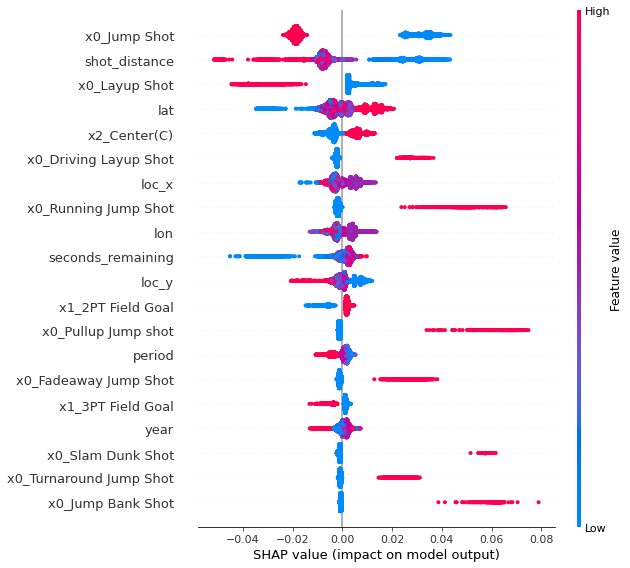

In [607]:
import shap  # package used to calculate Shap values
# For speed, we will calculate shap values on smaller subset of the validation data
data_for_prediction = X_train.copy()

explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(data_for_prediction)
shap.summary_plot(shap_values[1], data_for_prediction)

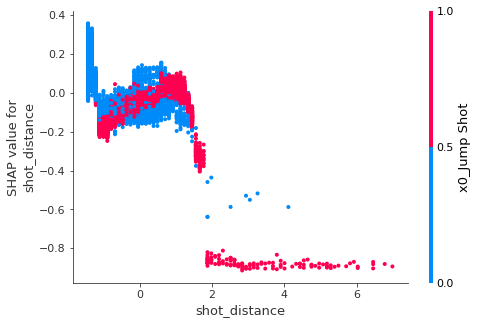

In [587]:
shap.dependence_plot("shot_distance",
                     shap_values[1],
                     features=X_train)
                     #interaction_index=None) 

### Force plot

In [588]:
data_for_prediction = X_train.sample(n=1000)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1],
                shap_values[1],
                data_for_prediction)

### Force plot pra observacoes especificas

In [589]:
y_train.mean()

0.44709831201050737

#### exemplo predict 0